# Importing modules

In [96]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

# Loading Data

In [97]:
train_dir = "/DATA/chest_xray/train/"
test_dir = "/DATA/chest_xray/test/"
val_dir = "/DATA/chest_xray/val/"

In [98]:
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))

In [102]:
pneumonia = os.listdir("/DATA/chest_xray/train/PNEUMONIA")
pneumonia_dir = "/DATA/chest_xray/train/PNEUMONIA"

In [103]:
NORMAL = os.listdir("/DATA/chest_xray/train/NORMAL")
NORMAL_dir = "/DATA/chest_xray/train/NORMAL"

# EDA

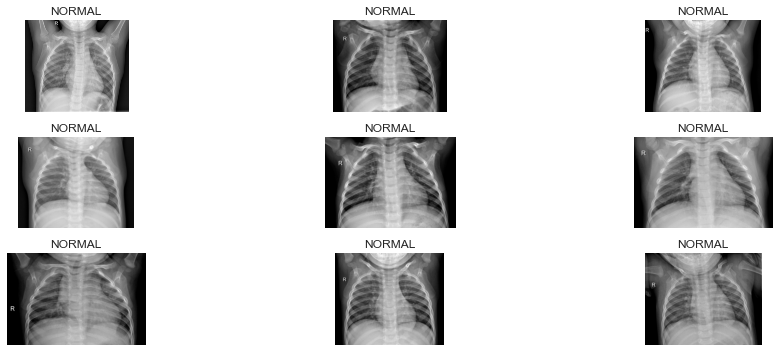

In [104]:
plt.figure(figsize=(15, 5))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(NORMAL_dir, NORMAL[i]))
    plt.title("NORMAL")
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

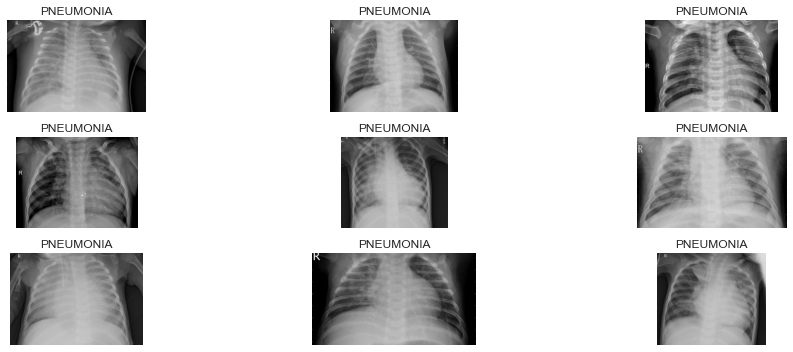

In [105]:
plt.figure(figsize=(15, 5))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.title("PNEUMONIA")
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    

plt.tight_layout()

In [106]:
import glob

pneumonia_train = glob.glob(train_dir+"/PNEUMONIA/*.jpeg")
normal_train = glob.glob(train_dir+"/NORMAL/*.jpeg")

In [107]:
data = pd.DataFrame(np.concatenate([[0]*len(normal_train) ,
                                    [1]*len(pneumonia_train)]),columns=["class"])

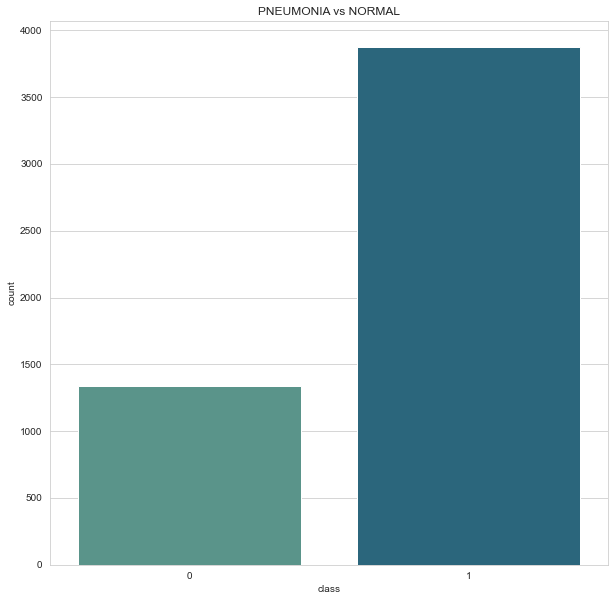

In [171]:
plt.figure(figsize=(10,10))
sns.countplot(data['class'],data=data,palette='crest',color='blue')
plt.title('PNEUMONIA vs NORMAL')
plt.show()

# Pre-processing - Data Augmentation

In [110]:
img_Datagen = ImageDataGenerator(
        rescale = 1/255,
        shear_range=10,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.5,2.0],
        width_shift_range = 0.2,
        rotation_range=20,
        fill_mode = 'nearest'
)
val_Datagen = ImageDataGenerator(
        rescale = 1/255
)

In [111]:
train = img_Datagen.flow_from_directory(train_dir,
                                       batch_size=64,
                                       class_mode='binary')

Found 5216 images belonging to 2 classes.


In [112]:
validation = val_Datagen.flow_from_directory(val_dir,
                                              batch_size=64,
                                              class_mode='binary')

Found 16 images belonging to 2 classes.


In [113]:
test = val_Datagen.flow_from_directory(test_dir,
                                       batch_size=64,
                                       class_mode='binary')

Found 624 images belonging to 2 classes.


In [114]:
img, label = next(train)

In [115]:
print("The shape of img:",img.shape)
print("The shape of label:",label.shape)

The shape of img: (64, 256, 256, 3)
The shape of label: (64,)


# # Creating the VGG Model

In [116]:
vgg_model = tf.keras.applications.VGG19(
    weights='imagenet',
    include_top = False,
)

for layer in vgg_model.layers:
    layer.trainable=False
    
x = vgg_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)

predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model = tf.keras.Model(inputs=vgg_model.input, outputs=predictions)

In [155]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=8)

In [118]:
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [53]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

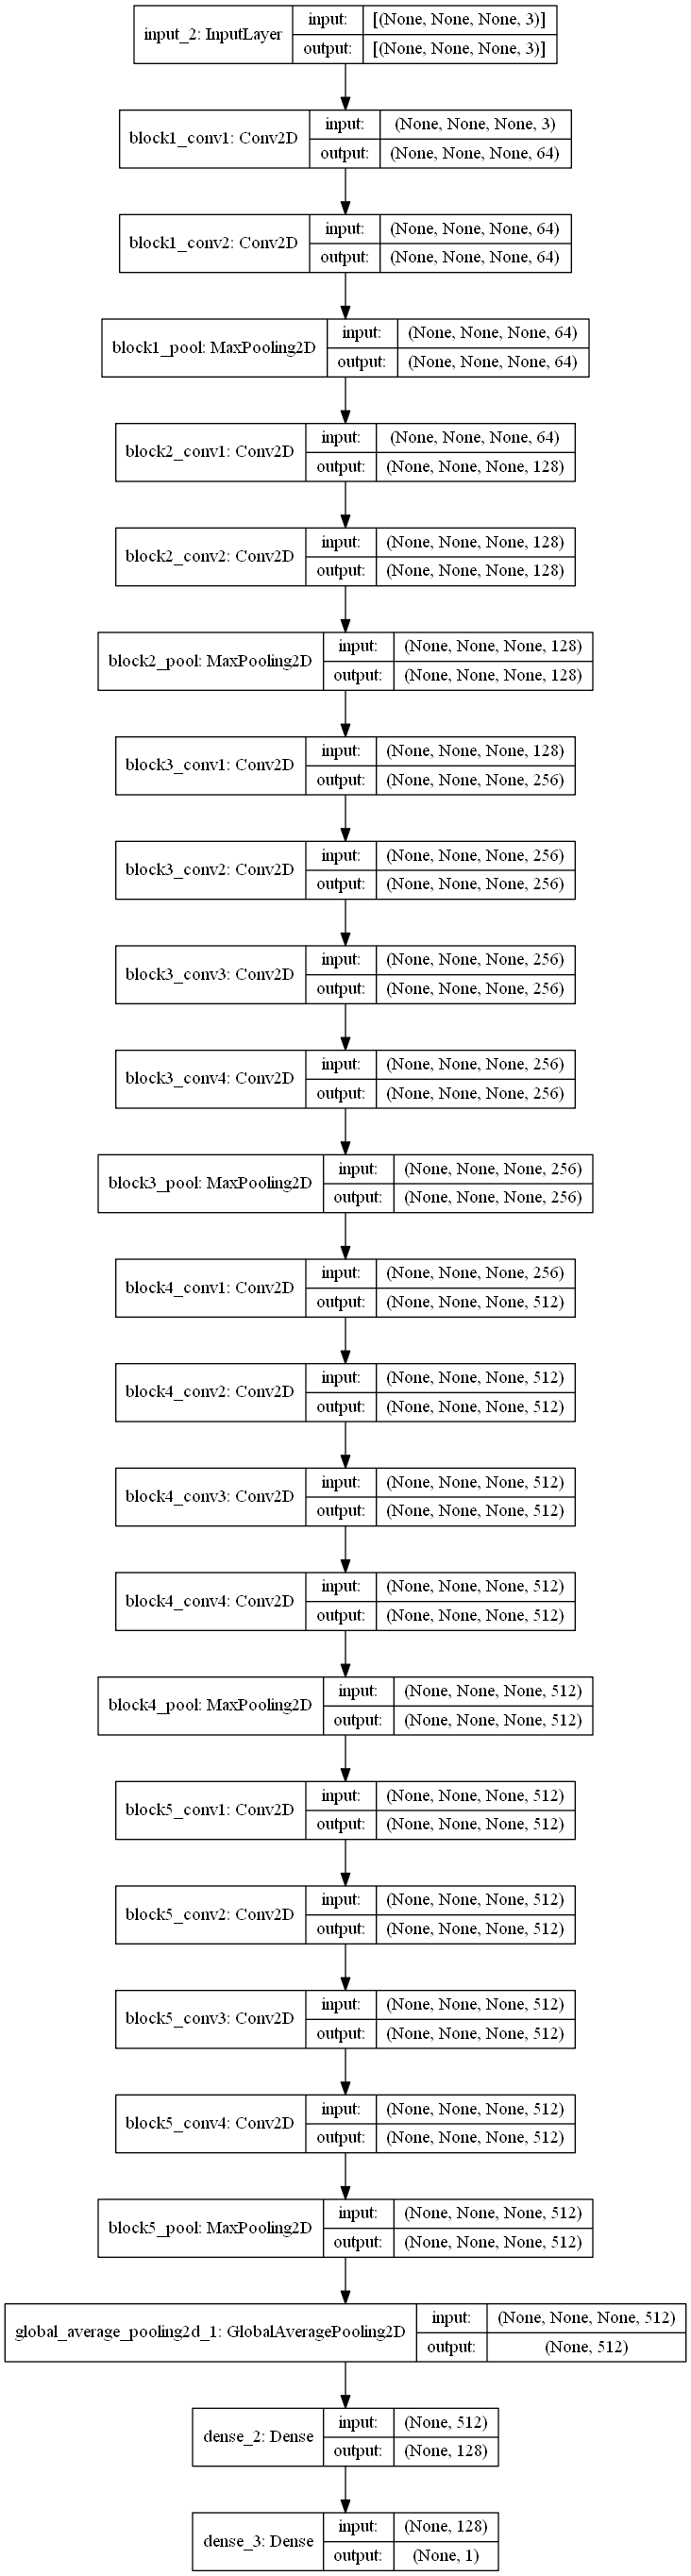

In [54]:
from tensorflow.keras.utils import to_categorical, plot_model
plot_model(model, to_file='cnn-mnist.png', show_shapes=True)

In [56]:
history = model.fit(train,epochs=30, 
                    validation_data=validation,
                     steps_per_epoch=50,
                    callbacks=[early_stopping,lr],
                    batch_size=64)

Epoch 1/30
50/50 [==============================] - 138s 3s/step - loss: 0.5208 - accuracy: 0.7383 - val_loss: 0.5320 - val_accuracy: 0.7500
Epoch 2/30
50/50 [==============================] - 139s 3s/step - loss: 0.4513 - accuracy: 0.7859 - val_loss: 0.5238 - val_accuracy: 0.8125
Epoch 3/30
50/50 [==============================] - 138s 3s/step - loss: 0.4198 - accuracy: 0.8044 - val_loss: 0.5556 - val_accuracy: 0.6875
Epoch 4/30
50/50 [==============================] - 138s 3s/step - loss: 0.4085 - accuracy: 0.8062 - val_loss: 0.4765 - val_accuracy: 0.7500
Epoch 5/30
50/50 [==============================] - 141s 3s/step - loss: 0.3639 - accuracy: 0.8334 - val_loss: 0.4789 - val_accuracy: 0.7500
Epoch 6/30
50/50 [==============================] - 139s 3s/step - loss: 0.3668 - accuracy: 0.8303 - val_loss: 0.5121 - val_accuracy: 0.8125
Epoch 7/30
50/50 [==============================] - 137s 3s/step - loss: 0.3506 - accuracy: 0.8349 - val_loss: 0.4421 - val_accuracy: 0.8125
Epoch 8/30
50

In [61]:
score = model.evaluate(train)

print("Train Loss is: ", score[0])
print("Train Accuracy is: ", score[1])

82/82 [==============================] - 224s 3s/step - loss: 0.2405 - accuracy: 0.8997
Train Loss is:  0.24054977297782898
Train Accuracy is:  0.8997315764427185


In [62]:
score = model.evaluate(test)

print("Test Loss is: ", score[0])
print("Test Accuracy is: ", score[1])

10/10 [==============================] - 27s 3s/step - loss: 0.3320 - accuracy: 0.8542
Test Loss is:  0.33197253942489624
Test Accuracy is:  0.8541666865348816


# Plotting results

Text(0.5, 1.0, 'Accuracy')

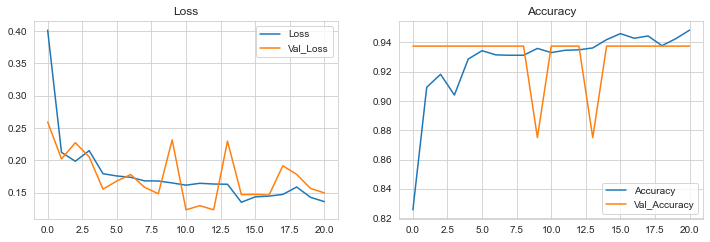

In [156]:
plt.figure(figsize=(12, 8))
plt.title('EVALUATION OF VGG19')

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy')

# Creating the ResNet Model

In [161]:
resnet_model = tf.keras.applications.ResNet50V2(
    weights='imagenet',
    include_top = False,
    input_shape = (224,224,3)
)

for layer in resnet_model.layers:
    layer.trainable=False
    
x = resnet_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
# output layer
predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model2 = tf.keras.Model(inputs=resnet_model.input, outputs=predictions)

In [162]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

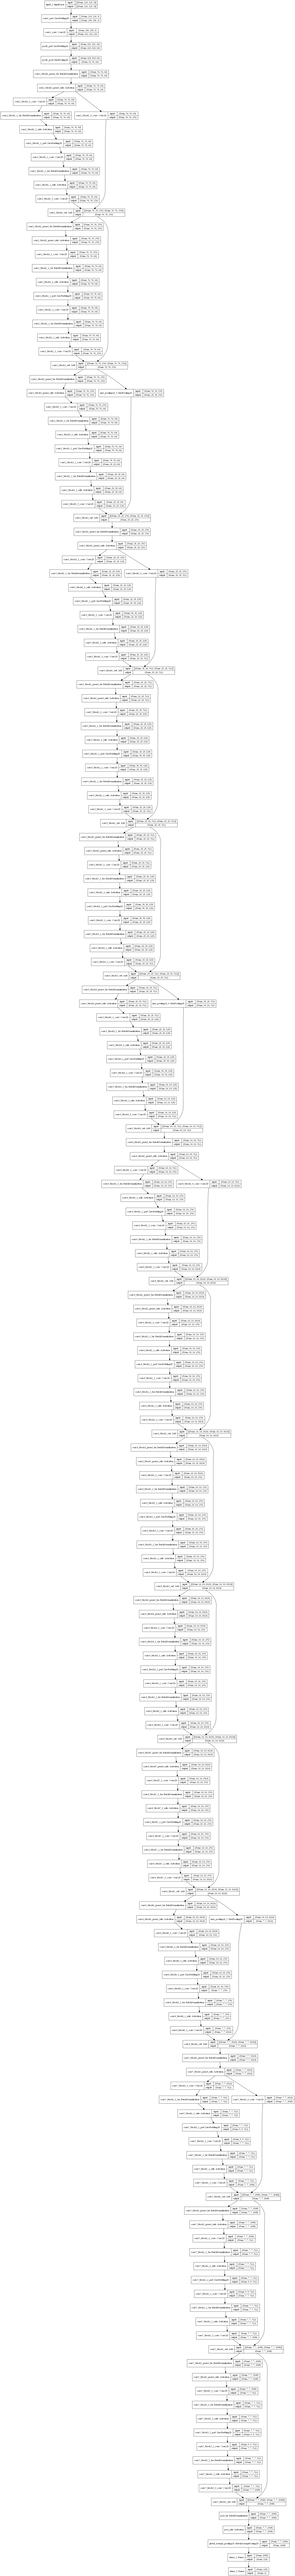

In [163]:
from tensorflow.keras.utils import to_categorical, plot_model
plot_model(model2, to_file='cnn-mnist.png', show_shapes=True)

In [164]:
model2.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [165]:
history = model2.fit(train,epochs=50, 
                    validation_data=validation,
                     steps_per_epoch=50,
                    callbacks=[early_stopping,lr],
                    batch_size=32)

Epoch 1/50
50/50 [==============================] - 73s 1s/step - loss: 0.2849 - accuracy: 0.8741 - val_loss: 0.2009 - val_accuracy: 0.8750
Epoch 2/50
50/50 [==============================] - 73s 1s/step - loss: 0.2095 - accuracy: 0.9097 - val_loss: 0.3819 - val_accuracy: 0.8750
Epoch 3/50
50/50 [==============================] - 72s 1s/step - loss: 0.1951 - accuracy: 0.9217 - val_loss: 0.1624 - val_accuracy: 0.9375
Epoch 4/50
50/50 [==============================] - 72s 1s/step - loss: 0.1745 - accuracy: 0.9277 - val_loss: 0.1848 - val_accuracy: 0.9375
Epoch 5/50
50/50 [==============================] - 73s 1s/step - loss: 0.1736 - accuracy: 0.9312 - val_loss: 0.3631 - val_accuracy: 0.8125
Epoch 6/50
50/50 [==============================] - 72s 1s/step - loss: 0.1630 - accuracy: 0.9372 - val_loss: 0.2061 - val_accuracy: 0.9375
Epoch 7/50
50/50 [==============================] - 71s 1s/step - loss: 0.1625 - accuracy: 0.9359 - val_loss: 0.2672 - val_accuracy: 0.8750
Epoch 8/50
50/50 [==

In [167]:
score = model2.evaluate(train)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

82/82 [==============================] - 123s 2s/step - loss: 0.1435 - accuracy: 0.9444
Train Loss:  0.14351990818977356
Train Accuracy:  0.9444018602371216


In [168]:
score = model2.evaluate(test)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])

10/10 [==============================] - 11s 1s/step - loss: 0.1994 - accuracy: 0.9199

Test loss:  0.19943587481975555
Test Accuracy:  0.9198718070983887


# Plotting results

Text(0.5, 1.0, 'Accuracy')

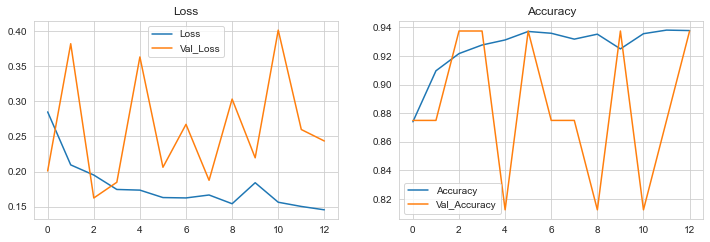

In [172]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy')